In [440]:
import shapefile
import glob
import rasterio.mask
import rasterio.warp
import shapely.geometry
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [441]:
from enum import Enum

class ShapeClass(Enum):
    CACAO = 1
    COFFEE = 2
    COMPLEX_OIL = 3
    NATIVEVEGE = 4
    OIL_PALM = 5
    RUBBER = 6
    UNKNOWN = 7
    SEASONAL = 8
    URBAN = 9
    WATER = 10
    OTHER_TREE = 11
    OTHER_NO_TREE = 12
    NATIVE_NO_TREE = 13
    WATER_OTHER = 14
    PEPPER = 15
    CASSAVA = 16
    TEA = 17
    RICE = 18
    BANANA_JUNG = 19
    BABY_PALM = 20
    CUT_OFF_REGROW = 21
    NATURAL_WETLAND = 22
    INTERCROP = 23
    DECIDUOUS_FOREST = 24
    STICK_PEPPER = 25
    FLOODED_PLANTATION = 26
    PINE_TREES = 27
    COCONUT = 28
    BAMBOO = 29
    SAVANA = 30
    MANGO = 31
    OTHER_FRUIT_TREE_CROP = 32
    WATER_MINE = 33

In [442]:
def polygon_nb_px_around_coordinates(coordinate, n, dataset):
    lat = coordinate[0]
    lon = coordinate[1]

    row, col = dataset.index(lat, lon)

    min_coord = rasterio.transform.xy(dataset.transform, row - n, col - n, offset='ul')
    max_coord = rasterio.transform.xy(dataset.transform, row + n, col + n, offset='lr')

    return shapely.geometry.box(min_coord[0], min_coord[1], max_coord[0], max_coord[1])

In [443]:
# Open shapefiles
shapefile_root_path = "labels/"
shapefiles_paths = glob.glob(shapefile_root_path + "**/*.shp")

In [444]:
# Create a dictionary which will contain all
# points classified in the opened shapefiles
# with their coordinates lat-lon
classes_points_coordinates = {}

# Initialize the dictionary
for i in range(1, 34):
    classes_points_coordinates[i] = []

# Add each points coordinate
# in its corresponding class
for path in shapefiles_paths:
    sf = shapefile.Reader(path)

    for shape_record in sf.shapeRecords():
        if shape_record.record.Class <= 33:
            current_list = classes_points_coordinates.get(shape_record.record.Class)
            current_list.append(shape_record.shape.points[0])
            classes_points_coordinates[shape_record.record.Class] = current_list

In [445]:
def write_raster_to_disk(raster, metadata, transform, crs, filename):
    metadata.update({
        "driver": "GTiff",
        "height": raster.shape[1],
        "width": raster.shape[2],
        "transform": transform,
        "crs": crs
    })

    # Write merged raster to disk
    with rasterio.open('./tiles/' + filename, "w", **metadata) as dest:
        dest.write(raster)

In [446]:
def raster_n_px_around_tagged_point(coordinates, nb_pixel_around, initial_raster):
    polygon = polygon_nb_px_around_coordinates(coordinates, nb_pixel_around, initial_raster)
    return rasterio.mask.mask(initial_raster, shapes=[polygon], crop=True)

In [447]:
NB_PIXEL_AROUND_POINT = 4

In [448]:
def tagged_points_bands_values(point_class, initial_raster):
    values = []
        
    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)

        values.append([
            np.mean(out_img[0]),
            np.mean(out_img[1]),
            np.mean(out_img[2]),
            np.mean(out_img[3]),
            np.mean(out_img[4]),
            np.mean(out_img[5]),
            np.mean(out_img[6]),
            np.mean(out_img[7]),
            #np.mean(out_img[8]),
            #np.mean(out_img[9]),
            #np.mean(out_img[10]),
        ])
     
    return np.array(values)

In [449]:
def write_raster_around_tagged_points(point_class, initial_raster):
    i = 0
    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)
        
        write_raster_to_disk(
            out_img,
            initial_raster.meta.copy(),
            out_transform,
            initial_raster.crs.to_proj4(),
            filename = str(ShapeClass(point_class).name) + '_' + str(i) + '.tif'
        )
        
        i += 1

In [450]:
def normalize_dataframe(dataframe, columns):
    scaler = preprocessing.MinMaxScaler() 
    scaled_values = scaler.fit_transform(dataframe[columns]) 
    dataframe[columns] = scaled_values
    return dataframe

In [451]:
def draw_bands_boxplots(df, hue):
    g = sns.FacetGrid(df, col="bands", col_wrap=4)
    g.map_dataframe(sns.boxplot, x="bands", y="value", hue=hue)
    g.add_legend()
    g.set_titles(col_template="{col_name}")
    g.set(xticklabels=[])

#  Coffee comparison to other entities

In [452]:
def coffee_comparison_to_other_entities(raster_path):
    # Open raster
    initial_raster = rasterio.open(raster_path) 
    
    # Get values for each label we are interested in
    coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster)
    pepper_values = tagged_points_bands_values(ShapeClass.PEPPER.value, initial_raster)
    nativevege_values = tagged_points_bands_values(ShapeClass.NATIVEVEGE.value, initial_raster)
    tea_values = tagged_points_bands_values(ShapeClass.TEA.value, initial_raster)
    urban_values = tagged_points_bands_values(ShapeClass.URBAN.value, initial_raster)
    water_values = tagged_points_bands_values(ShapeClass.WATER.value, initial_raster)
    
    # Create dataframes from those values
    columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic']
    coffee_df = pandas.DataFrame(coffee_values, columns=columns).assign(label="Coffee")
    pepper_df = pandas.DataFrame(pepper_values, columns=columns).assign(label="Pepper")
    nativevege_df = pandas.DataFrame(nativevege_values, columns=columns).assign(label="Native Vegetation")
    tea_df = pandas.DataFrame(tea_values, columns=columns).assign(label="Tea")
    urban_df = pandas.DataFrame(urban_values, columns=columns).assign(label="Urban")
    water_df = pandas.DataFrame(water_values, columns=columns).assign(label="Water")

    # Concatenate all those dataframe into one
    concat_df = pandas.concat([coffee_df, pepper_df, nativevege_df, tea_df, urban_df, water_df])
    
    normalize_dataframe(concat_df, columns)
    
    df = pandas.melt(concat_df, id_vars=['label'], var_name=['bands'])
    
    draw_bands_boxplots(df, "label")
    
    # Draw Scatter plot
    # sns.pairplot(concat_df, hue="label", height=2.5, palette="Set3")

## Dry Season (2016 - 2018) 

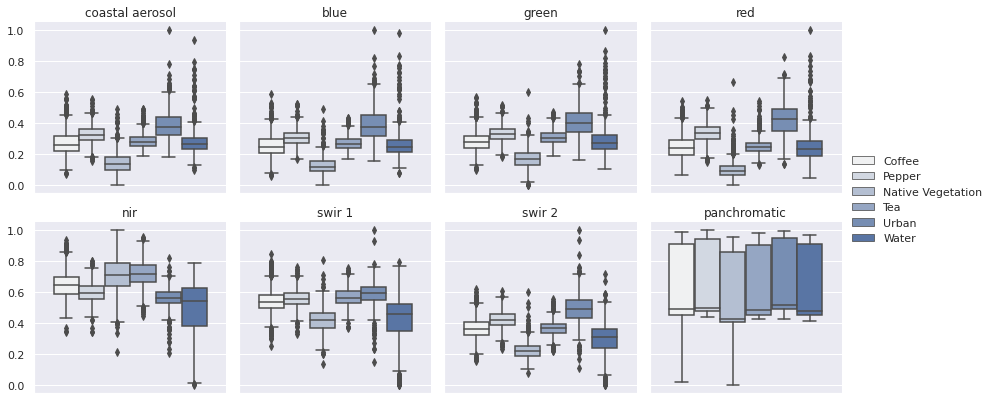

In [453]:
coffee_comparison_to_other_entities('./Vietnam_2016-2018_dry_season/merged.tif')

## Wet Season (2016 - 2018)

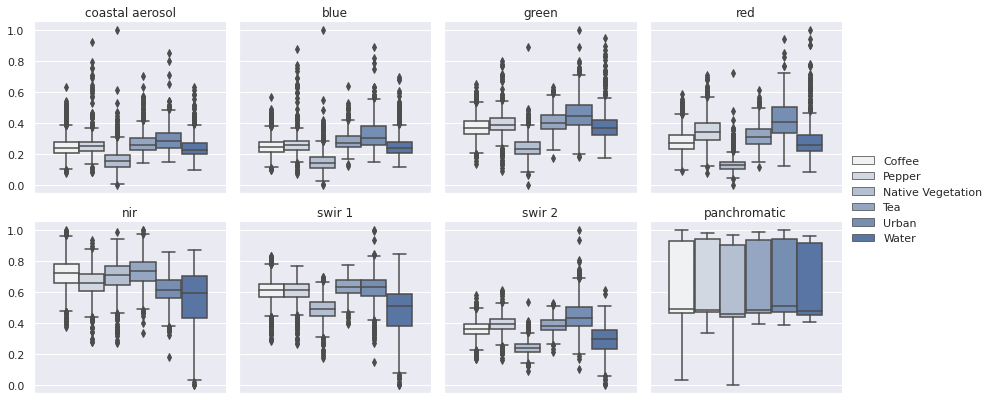

In [454]:
coffee_comparison_to_other_entities('./Vietnam_2016-2018_wet_season/merged.tif')

# Coffee comparison by season

Si l'on compare le café entre la saison sèche au Vietnam (novembre à avril) et la saison humide (mai à octobre), on peut remarquer certaines différences intéressantes.


In [455]:
dry_2014_raster_path = './Vietnam_2014-2016_dry_season/merged.tif'
dry_2014_initial_raster = rasterio.open(dry_2014_raster_path) # Open raster
dry_2014_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, dry_2014_initial_raster)

wet_2014_raster_path = './Vietnam_2014-2016_wet_season/merged.tif'
wet_2014_initial_raster = rasterio.open(wet_2014_raster_path) # Open raster
wet_2014_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, wet_2014_initial_raster)

dry_2016_raster_path = './Vietnam_2016-2018_dry_season/merged.tif'
dry_2016_initial_raster = rasterio.open(dry_2016_raster_path) # Open raster
dry_2016_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, dry_2016_initial_raster)

wet_2016_raster_path = './Vietnam_2016-2018_wet_season/merged.tif'
wet_2016_initial_raster = rasterio.open(wet_2016_raster_path) # Open raster
wet_2016_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, wet_2016_initial_raster)

Dry Season (2014):
--------------
        coastal aerosol         blue        green          red          nir  \
count      4109.000000  4109.000000  4109.000000  4109.000000  4109.000000   
mean        225.331901   272.472294   501.766884   489.636689  2467.888274   
std          44.412898    47.188685    66.179310   101.602220   288.690739   
min          66.422222   117.883333   310.272222   187.222222  1365.566667   
25%         195.858025   240.272222   456.066667   418.400000  2269.765432   
50%         219.866667   267.505556   493.877778   477.327160  2459.405556   
75%         251.500000   299.488889   539.820988   547.266667  2649.350000   
max         439.038889   497.018519   812.345679   881.567901  3574.253086   

            swir 1       swir 2  panchromatic  
count  4109.000000  4109.000000   4109.000000  
mean   1735.333773   957.370980   2828.296068  
std     219.447980   161.895015    150.339264  
min     818.300000   423.544444   2411.975000  
25%    1588.586420   8

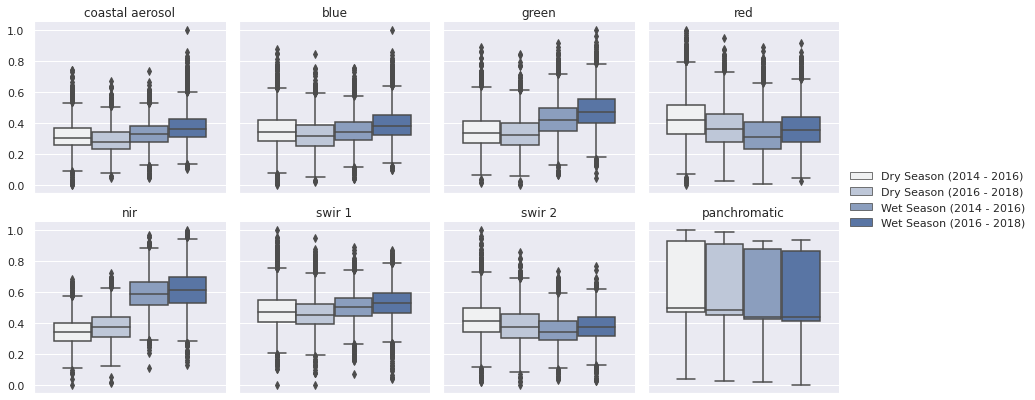

In [456]:
columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic']

# Create a dataframe containing the data of each bands
dry_2014_coffee_df = pandas.DataFrame(dry_2014_coffee_values, columns=columns).assign(timePeriod='Dry Season (2014 - 2016)')
dry_2016_coffee_df = pandas.DataFrame(dry_2016_coffee_values, columns=columns).assign(timePeriod='Dry Season (2016 - 2018)')
wet_2014_coffee_df = pandas.DataFrame(wet_2014_coffee_values, columns=columns).assign(timePeriod='Wet Season (2014 - 2016)')
wet_2016_coffee_df = pandas.DataFrame(wet_2016_coffee_values, columns=columns).assign(timePeriod='Wet Season (2016 - 2018)')

sns.set(rc={'figure.figsize':(15,12)})

concat_df = pandas.concat([dry_2014_coffee_df, dry_2016_coffee_df, wet_2014_coffee_df, wet_2016_coffee_df])

normalize_dataframe(concat_df, columns)

df = pandas.melt(concat_df, id_vars=['timePeriod'], var_name=['bands'])

draw_bands_boxplots(df, "timePeriod")

print("Dry Season (2014):\n--------------\n", dry_2014_coffee_df.describe(), "\n")
print("Dry Season (2016):\n--------------\n", dry_2016_coffee_df.describe(), "\n")
print("Wet Season (2014):\n--------------\n", wet_2014_coffee_df.describe(), "\n")
print("Wet Season (2016):\n--------------\n", wet_2016_coffee_df.describe(), "\n")

## Coffee comparison each two months (2014-2020)

Sur la période novembre à décembre, la variabilité des bandes _coastal aerosol_, _red_, _green_, _blue_ est la plus petite.

De la même manière la période septembre à octobre a la variabilité la plus basses pour les bandes _swir1_, _swir2_ et _tirs2_.

Mars à Avril à la bande _nir_ avec la plus petite variabilité, Juiller à Août celle de _panchromatic_ et enfin Janvier à Février celle de _tirs1_.


...



On peut aussi observer que les valeurs des différentes bandes ont tendances à être à leur plus bas vers décembre.

In [457]:
coffee_values_list = []

raster_path_01 = './Vietnam_01_02/merged.tif'
initial_raster_01 = rasterio.open(raster_path_01) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_01)) 

raster_path_02 = './Vietnam_03_04/merged.tif'
initial_raster_02 = rasterio.open(raster_path_02) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_02))

raster_path_03 = './Vietnam_05_06/merged.tif'
initial_raster_03 = rasterio.open(raster_path_03) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_03))

raster_path_04 = './Vietnam_07_08/merged.tif'
initial_raster_04 = rasterio.open(raster_path_04) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_04))

raster_path_05 = './Vietnam_09_10/merged.tif'
initial_raster_05 = rasterio.open(raster_path_05) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_05))

raster_path_06 = './Vietnam_11_12/merged.tif'
initial_raster_06 = rasterio.open(raster_path_06) # Open raster
coffee_values_list.append(tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster_06))


 January - February 
----------------
        coastal aerosol         blue        green          red          nir  \
count      4109.000000  4109.000000  4109.000000  4109.000000  4109.000000   
mean          0.205271     0.226209     0.347082     0.327257     0.346079   
std           0.061804     0.068188     0.080277     0.091130     0.089853   
min           0.006410     0.014345     0.112500     0.095339     0.000000   
25%           0.163121     0.178943     0.290916     0.260596     0.283754   
50%           0.201644     0.221088     0.339634     0.318198     0.342547   
75%           0.246096     0.269115     0.395963     0.383964     0.400115   
max           0.480913     0.535994     0.718308     0.649903     0.705151   

            swir 1       swir 2  panchromatic  
count  4109.000000  4109.000000   4109.000000  
mean      0.450472     0.396303      0.628867  
std       0.094564     0.099069      0.215373  
min       0.051965     0.053415      0.032945  
25%       0.38802

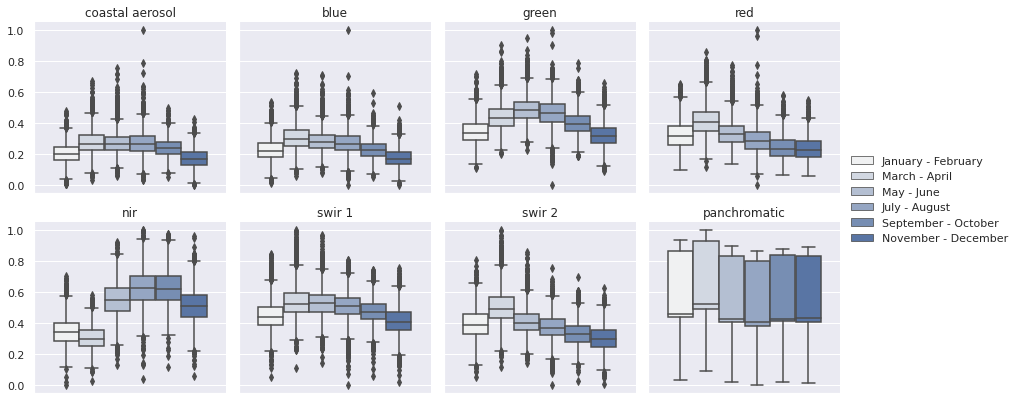

In [458]:
columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic']

timePeriods = [
    'January - February', 'March - April', 'May - June', 
    'July - August', 'September - October', 'November - December'
]

coffee_df_list = []

for i, timePeriod in enumerate(timePeriods):
    # Create a dataframe containing the data of each bands and
    # add a value indicating the corresponding time period
    coffee_df_list.append(pandas.DataFrame(coffee_values_list[i], columns=columns).assign(timePeriod=timePeriod))

# Set seaborn figures sizes
sns.set(rc={'figure.figsize':(15,12)})

# Concatenate the dataframe of each time periods into one
concat_df = pandas.concat(coffee_df_list)

normalize_dataframe(concat_df, columns)

# Print statistical data pertaining to each time period
for timePeriod in timePeriods:
    print('\n', timePeriod, '\n----------------\n', concat_df.loc[concat_df['timePeriod'] == timePeriod].describe())

df = pandas.melt(concat_df, id_vars=['timePeriod'], var_name=['bands'])

draw_bands_boxplots(df, "timePeriod")